In [1]:
from gwdatafind import find_urls
import gwpy as gwpy
from gwpy.io.gwf import get_channel_names
from gwpy.timeseries import TimeSeries
from gwpy.signal import filter_design
from gwpy.plot import Plot
import pycbc as pycbc
from pycbc import frame
from pycbc.waveform import get_td_waveform
from pycbc.detector import Detector
import os, glob
import numpy as np
from numpy.lib.stride_tricks import as_strided
import pylab

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
t_window = 6 #16 #12 # s
t_stride = 1 #4 #12 # s
fcalib_lo = 16 # Hz

In [3]:
#start = 1126256640 # GW150914 file start
start = 1126259446 # GW150914: 32 s window start, until 1126259478

#start = 1126072320 # O1, first: lots of nans
#start = 1126076416 # O1, second

#end_offset = 1
end_offset = t_window - t_stride # how much to read into following file, for continuity at file boundaries

end = 1126080512+end_offset # O1, third
end = start+t_window #32 # s

host_cvmfs = 'datafind.gw-openscience.org'
host_gwosc = 'gw-openscience.org'
files = find_urls('H', 'H1_LOSC_4_V1', start, end, host=host_cvmfs) # fails if invalid range given (e.g. start > stop)
print(files)

print(os.getcwd())
mydir = 'data/O1/test'
# https://www.gw-openscience.org/archive/data/O1/1125122048/H-H1_LOSC_4_V1-1126072320-4096.gwf
# https://www.gw-openscience.org/archive/data/O1/1125122048/H-H1_LOSC_4_V1-1126076416-4096.gwf
# ...
# https://www.gw-openscience.org/archive/data/O1/1136656384/H-H1_LOSC_4_V1-1137250304-4096.gwf
myfiles = ['%s/%s'%(mydir, f.split('/')[-1]) for f in files]
print(myfiles)
for f in myfiles:
    assert os.path.exists(f)

['file://localhost/cvmfs/gwosc.osgstorage.org/gwdata/O1/strain.4k/frame.v1/H1/1126170624/H-H1_LOSC_4_V1-1126256640-4096.gwf']
/export/home/phys/mbandrews/work/gw
['data/O1/test/H-H1_LOSC_4_V1-1126256640-4096.gwf']


In [4]:
f = myfiles[0]
print(get_channel_names(f))
kdq, kinj, kdata = get_channel_names(f)
print(kdq, kinj, kdata)

['H1:LOSC-DQMASK', 'H1:LOSC-INJMASK', 'H1:LOSC-STRAIN']
H1:LOSC-DQMASK H1:LOSC-INJMASK H1:LOSC-STRAIN


In [5]:
series = TimeSeries.read(myfiles, kdata, start=start, end=end)
series_dq = TimeSeries.read(myfiles, kdq, start=start, end=end)
series_inj = TimeSeries.read(myfiles, kinj, start=start, end=end)

# see: https://gwpy.github.io/docs/stable/api/gwpy.timeseries.TimeSeries.html#gwpy.timeseries.TimeSeries
print(series)
print('sample_rate:',series.sample_rate)
print('t0:',series.t0)
t0 = series.t0.value
print('dt:',series.dt)
dt = series.dt.value
print('duration:',series.duration)
print('len(series):',len(series))
print('duration/dt:',series.duration.value/series.dt.value)

print('times:',series.times)
print('times:',series.times.value.shape)
print('times[-1]:',series.times.value[-1])
print('len(times):',len(series.times))
print('xspan:',series.xspan)

times = series.times.value
print('type(times):',type(times))
print('times.shape:',times.shape)
print('times[0]:', times[0], 'times[-1]:', times[-1])

TimeSeries([ 2.17704028e-19,  2.08763900e-19,  2.39681183e-19,
            ..., -2.20830949e-19, -2.29131370e-19,
            -2.24629575e-19]
           unit: dimensionless,
           t0: 1126259446.0 s,
           dt: 0.000244140625 s,
           name: H1:LOSC-STRAIN,
           channel: H1:LOSC-STRAIN)
sample_rate: 4096.0 Hz
t0: 1126259446.0 s
dt: 0.000244140625 s
duration: 6.0 s
len(series): 24576
duration/dt: 24576.0
times: [1.12625945e+09 1.12625945e+09 1.12625945e+09 ... 1.12625945e+09
 1.12625945e+09 1.12625945e+09] s
times: (24576,)
times[-1]: 1126259451.9997559
len(times): 24576
xspan: [1126259446.0 ... 1126259452.0)
type(times): <class 'numpy.ndarray'>
times.shape: (24576,)
times[0]: 1126259446.0 times[-1]: 1126259451.9997559


In [6]:
#t_window = 12 # s
#t_stride = 12 # s
window = int(t_window//dt) # steps
stride = int(t_stride//dt) # steps
assert t_window <= series.duration.value
assert t_window >= t_stride
#times = times
#print(times.shape)
#print(times.strides)
print(window, stride)
print(len(series.crop(t0, t0+t_window)))
print(series.crop(t0, t0+t_window).duration)

byte_strides = (times.strides[0]*stride, times.strides[0])
nsegs = (len(times)-window)/stride + 1
if nsegs%1 != 0:
    print(nsegs)
    print('WARNING: series will be truncated!')
nsegs = int(np.floor(nsegs))
print(nsegs)
#print(type(times.strides))
timesegs = as_strided(times, shape=(nsegs, window), strides=byte_strides)
print('len(timesegs):',len(timesegs))
assert nsegs == len(timesegs)

#deltats = []
nwrite = 0
for i in range(len(timesegs)):
    if i > 2:
        pass
        #break
    tseg = timesegs[i]
    tstart, tend = tseg[0], tseg[-1]+dt # stride generates [t0, t1), so need to add +dt to get full t_window
    batch = series.crop(tstart, tend)
    dqs = series_dq.crop(tstart, tend)
    injs = series_inj.crop(tstart, tend)
    #print(batch[0], batch[1], batch[2], batch[3])
    # Make sure no NaNs
    if np.any(np.isnan(batch.value)):
        pass
        continue
    # Make sure DQ:CAT3 for both CBC and burst
    if np.any(dqs.value != 127):
        pass
        continue
    # Make sure there were no hardware injs
    if np.any(injs.value != 31):
        pass
        continue
    #else:
    #    print(i)
    #    break
    #print('batch.duration:',batch.duration)
    #print('len(batch):', len(batch), 'len(tseg):', len(tseg), 'tend-start:',tend-tstart)
    #deltats.append(tseg[0])
    #print(tseg[0], tseg[1], tseg[2], tseg[3])#, seg[-1])
    nwrite += 1
print('timesegs[-1][-1]:',timesegs[-1][-1])
#print('deltat:',deltats[1]-deltats[0])
print('nwrite: %d / nsegs: %d'%(nwrite,nsegs))

24576 4096
24576
6.0 s
1
len(timesegs): 1
timesegs[-1][-1]: 1126259451.9997559
nwrite: 1 / nsegs: 1


# Plot time series

In [7]:
def plot_series(series, xlims=None, ylims=None, title='time series', ylabel='Amplitude [strain]'):
    plot = series.plot(title='LIGO-Hanford, %s'%(title), ylabel=ylabel, color='gwpy:ligo-hanford')
    #print(plot.axes[0])
    if xlims is not None:
        plot.axes[0].set_xlim(xlims[0], xlims[1])
    if ylims is not None:
        plot.axes[0].set_ylim(ylims[0], ylims[1])
    plot.show()

def plot_asd(series, w=(4,2), xlims=None, ylims=None):
    asd = series.asd(*w)
    # => delta_f = 1/4 = 0.25 Hz
    plot = asd.plot(title='LIGO-Hanford, amplitude spectral density (ASD)', ylabel=r'ASD [$\sqrt{Hz}$]', color='gwpy:ligo-hanford')
    #print(plot.axes[0])
    if xlims is not None:
        plot.axes[0].set_xlim(xlims[0], xlims[1])
    if ylims is not None:
        plot.axes[0].set_ylim(ylims[0], ylims[1])
    plot.show()

def plot_psd(series, w=(4,2), xlims=None, ylims=None):
    # see: https://gwpy.github.io/docs/stable/api/gwpy.timeseries.TimeSeries.html#gwpy.timeseries.TimeSeries.psd
    psd = series.psd(*w) # = (total_time_duration=sgdelta_t, stride_overlap=2 (default calculated internally as appropriate for window fn))
    # => delta_f = 1/4 = 0.25 Hz
    plot = psd.plot(title='LIGO-Hanford, power spectral density (PSD)', ylabel=r'PSD [Hz]', color='gwpy:ligo-hanford')
    #plot.axes[1].set_ylim(1e-20, 1e-15)
    if xlims is not None:
        plot.axes[0].set_xlim(xlims[0], xlims[1])
    if ylims is not None:
        plot.axes[0].set_ylim(ylims[0], ylims[1])
    plot.show()
    return psd

def _fft_length_default(dt):
    # from https://github.com/gwpy/gwpy/blob/26f63684db17104c5d552c30cdf01248b2ec76c9/gwpy/timeseries/timeseries.py#L44
    """Choose an appropriate FFT length (in seconds) based on a sample rate
    Parameters
    ----------
    dt : `~astropy.units.Quantity`
        the sampling time interval, in seconds
    Returns
    -------
    fftlength : `int`
        a choice of FFT length, in seconds
    """
    return int(max(2, np.ceil(2048 * dt)))

def whiten_series(series, w=(4,2), t_trunc=None, dt=1./4096.):
    # pycbc
    # pycbc does truncation by default
    # comparing: https://github.com/gwpy/gwpy/blob/v2.0.4/gwpy/timeseries/timeseries.py#L1669
    # and https://pycbc.org/pycbc/latest/html/gw150914.html?highlight=whiten + https://pycbc.org/pycbc/latest/html/_modules/pycbc/types/timeseries.html#TimeSeries.whiten
    #series_pycbc = series.to_pycbc()
    #wht = series_pycbc.whiten(series.duration.value, _fft_length_default(series.dt.value))
    #wht = TimeSeries.from_pycbc(wht)
    # gwpy
    wht = series.whiten(*w)
    # truncate corrupted ends
    # from: https://pycbc.org/pycbc/latest/html/_modules/pycbc/types/timeseries.html#TimeSeries.whiten
    if t_trunc is None:
        return wht
    elif t_trunc == -1:
        max_filter_duration = _fft_length_default(series.dt.decompose().value)
        max_filter_len = int(max_filter_duration * series.sample_rate.decompose().value)
        t_len = int(max_filter_len/2)
        wht = wht[t_len:-t_len]
        return wht
    else:
        t_len = int(t_trunc/dt)
        print('In whitening, truncating by % s or len(t_trunc) = %d'%(t_trunc, t_len))
        wht = wht[t_len:-t_len]
        return wht

def filter_band_notch(wht, fsg_lo=35., fsg_hi=250.):
    # define bandpass
    bp = filter_design.bandpass(fsg_lo, fsg_hi, series.sample_rate)
    # define notches
    notches = [filter_design.notch(line, series.sample_rate) for line in (60, 120, 180)]
    # chain filters
    zpk = filter_design.concatenate_zpks(bp, *notches)
    # set filtfilt=True to filter both backwards and forwards to preserve the correct phase at all frequencies
    # see also: https://gwpy.github.io/docs/stable/api/gwpy.timeseries.TimeSeries.html#gwpy.timeseries.TimeSeries.filter
    bp = wht.filter(zpk, filtfilt=True)
    #'''
    return bp

def process_strain(series, fcalib_lo=16., fcalib_hi=2048, t_trunc=None, dt=1./4096.):

    # Apply calib highpass
    series_bp = series.highpass(fcalib_lo) #.lowpass(fcalib_hi)
    plot_series(series_bp, ylims=[-7.5e-19, 7.5e-19])

    # Whiten
    wht = whiten_series(series_bp, t_trunc=t_trunc, dt=dt)
    plot_series(wht)#, ylims=[-10., 10.])
    #plot_asd(wht, w=(4,2), xlims=[fcalib_lo, fcalib_hi])#, ylims=[1.e-28, 1.e-19])
    print('duration:', wht.duration)

    # Apply analysis bandpass
    bp = filter_band_notch(wht)
    plot_series(bp, ylims=[-5., 5.])
    
    return bp

def make_bbh(m1, m2, dist, dec, asc, pol, t_end, fcalib_lo=16., dt=1./4096.):

    # Make waveform
    # from: https://pycbc.org/pycbc/latest/html/detector.html#antenna-patterns-and-projecting-a-signal-into-the-detector-frame
    # and https://pycbc.org/pycbc/latest/html/waveform.html#generating-one-waveform-in-multiple-detectors
    #import pylab
    #from pycbc.waveform import get_td_waveform
    #from pycbc.detector import Detector

    det_h1 = Detector('H1')
    #det_l1 = Detector('L1')
    #det_v1 = Detector('V1')

    # We get back the fp and fc antenna pattern weights.
    # These factors allow us to project a signal into what the detector would
    # observe
    fp, fc = det_h1.antenna_pattern(asc, dec, pol, t_end)

    # Generate the waveform
    hp, hc = get_td_waveform(approximant='SEOBNRv4',
                             mass1=m1, # in M_sun. GW150914: ~35M_sun
                             mass2=m2, # in M_sun. GW150914: ~35M_sun
                             #spin1z=0.9,
                             #spin2z=0.4,
                             inclination=0.,#1.23, # [0 (default), pi) # angle between the orbital angular momentum L and the line-of-sight at the reference frequency
                             #coa_phase=2.45, # [0, 2pi)
                             delta_t=dt,
                             distance=dist, # distance from detector, in Mpc: GW150914: ~300Mpc
                             f_lower=fcalib_lo)
                             #f_lower=40)

    ## Apply the factors to get the detector frame strain
    ht = fp*hp + fc*hc

    # The projection process can also take into account the rotation of the
    # earth using the project wave function.
    hp.start_time += t_end
    hc.start_time += t_end
    ht = det_h1.project_wave(hp, hc,  asc, dec, pol)
    #signal_h1 = det_h1.project_wave(hp, hc,  right_ascension, declination, polarization)
    #signal_l1 = det_l1.project_wave(hp, hc,  right_ascension, declination, polarization)
    #signal_v1 = det_v1.project_wave(hp, hc,  right_ascension, declination, polarization)

    #ht.resize(len(series))
    gw = TimeSeries.from_pycbc(ht)
    plot_series(gw)
    print('Strain, max:',gw.max())
    return gw

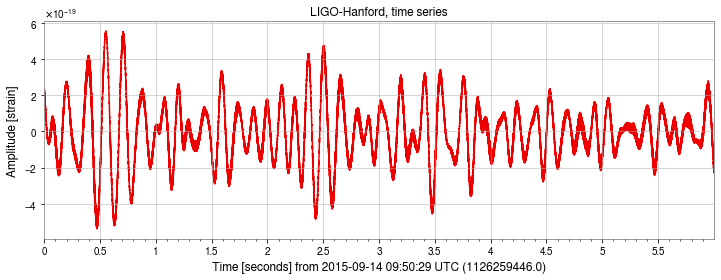

In [8]:
plot_series(series)
#plot_series(series_dq, title='DQ status')
#plot_series(series_inj, title='inj status')

duration: 6.0 s


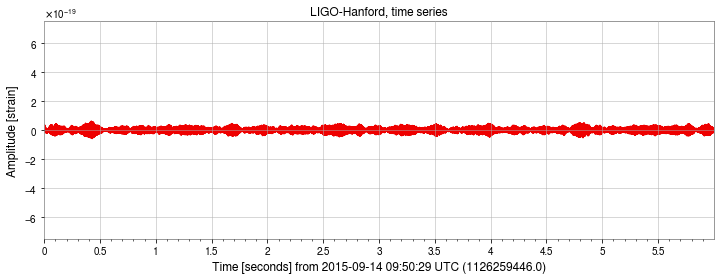

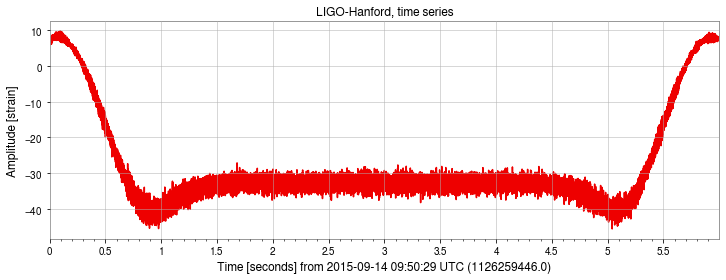

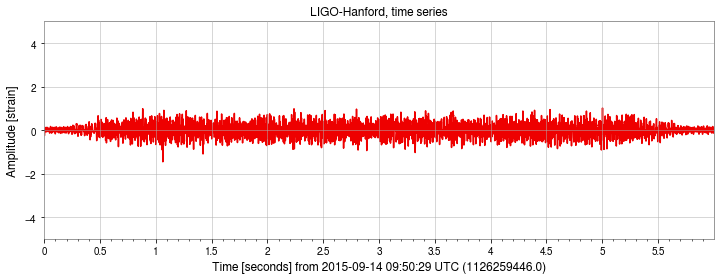

In [9]:
bg = process_strain(series, fcalib_lo=fcalib_lo, dt=dt)

Strain, max: 1.071970525674088e-21
1126259439.0544434 s 10.97119140625 s
In whitening, truncating by 2.0 or len(t_trunc) = 8192
duration: 2.0 s
8192


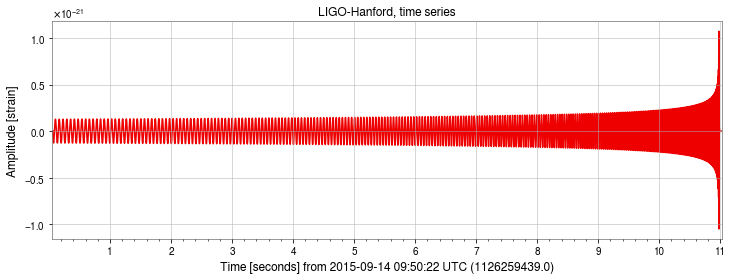

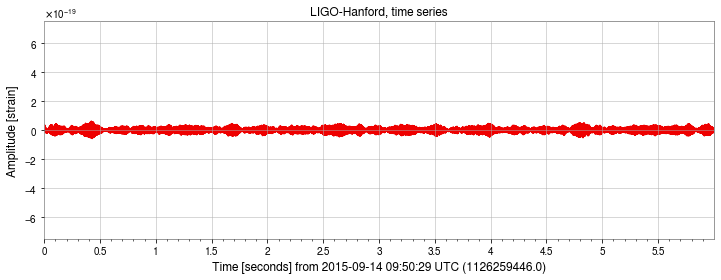

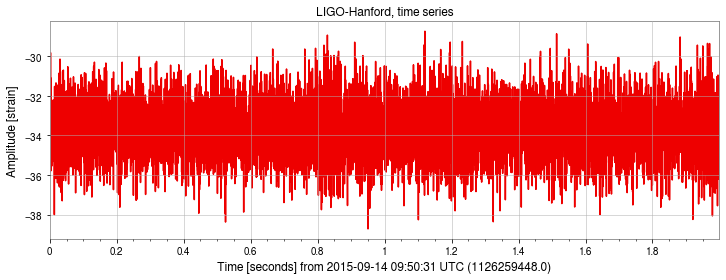

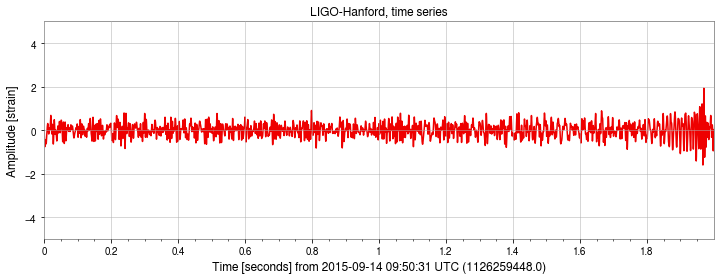

In [24]:
# Choose a GPS end time, sky location, and polarization phase for the merger
# NOTE: Right ascension and polarization phase runs from 0 to 2pi
#       Declination runs from pi/2. to -pi/2 with the poles at pi/2. and -pi/2.
# See known events: https://www.gw-openscience.org/eventapi/html/allevents/

t_trunc = 2. # s: how much to truncate at start and end of series after whitening, to remove artifacts
t_eff = t_window - 2*(t_trunc)
t_pad_lo = 0.25 # s how near to left end of t_eff to place signal
t_pad_hi = 0. # s how near to right end of t_eff to place signal

m1    = 10 # in M_sun. GW150914: ~35M_sun. [10, 100] -> [10, 50]
m2    = 10 # in M_sun. GW150914: ~30M_sun. [10, 100] -> [10, 50]
dist  = 2.e2 # distance to detector, in Mpc, [1e2, 5e3], Andromeda galaxy about ~< 1 Mpc away from Earth.
dec   = 0.65 # declination: [-pi/2, pi/2)
asc   = 0. # right ascension: [0, 2pi]
pol   = 0. # polarization: [-pi, pi) or [0, 2pi] (controls phase of wave)
t_end = end-4 #-24 # end of GW
t_end = end-(t_trunc+t_pad_hi)
#t_end = end-(t_trunc+t_eff-t_pad_lo)

sg = make_bbh(m1, m2, dist, dec, asc, pol, t_end, fcalib_lo, dt)#.crop(t_end-t_window-1, t_end)
print(sg.t0, sg.duration)
#sg = process_strain(sg)
sb = series.inject(sg)
sb = process_strain(sb, fcalib_lo=fcalib_lo, t_trunc=t_trunc, dt=dt)
print(len(sb))

# Making spectrograms

In [11]:
def plot_qt(qt, xlims=None, ylims=None):
    plot = qt.plot(title='LIGO-Hanford, Q-transform spectrogram', yscale='log')
    #print(plot.axes[0])
    if xlims is not None:
        plot.axes[0].set_xlim(xlims[0], xlims[1])
    if ylims is not None:
        plot.axes[0].set_ylim(ylims[0], ylims[1])
    plot.colorbar(cmap='viridis', label='Normalized energy')
    plot.show()

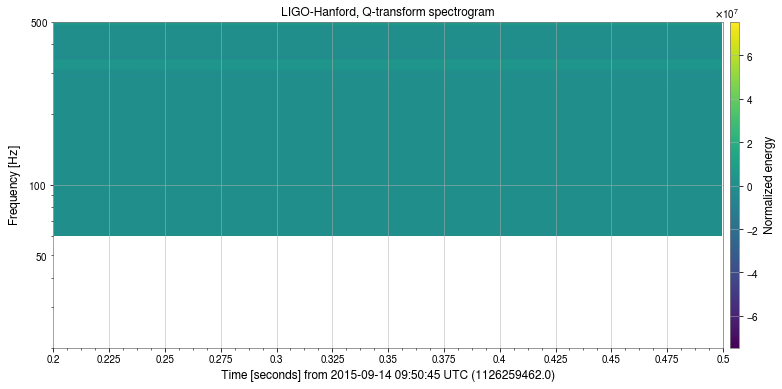

In [12]:
# Save computation/memory by only calculating **output** spectrogram on time segment of interest
# WARNING: Need to use sufficiently large time window around **input** waveform 
# in order to get good freq resolution in Fourier decomposition: about sg +/- 16 s

# peak position of different rois
#sgfirst = 1126259591 + 0.2 # the first glitch
#sgfirst = 1126259462 + 0.2 # this signal
#sfirst = 1126258757 + 16*60 + 6 + 0.3 # another glitch

# For spectrograms, need to choose sufficiently long time duration ~ 32 s
# to ensure good resolution and range in freq domain / Fourier space
sgfirst = 1126259446
sgdelta_t = 32
sglast = sgfirst + sgdelta_t

#qfirst = 1126259591 + 0.2 # the first glitch
qfirst = 1126259462 + 0.2 # this signal
#qfirst = 1126258757 + 16*60 + 6 + 0.3 # another glitch
qlast = qfirst + 0.3

# NOTE: whitening is only really for cleaning time series
# spectrograms are cleaner without whitening
# but can still benefit from bandpass
qt = series.q_transform(outseg=(qfirst, qlast))
plot_qt(qt, ylims=[20., 500.])